A CNN is a neural network: an algorithm used to recognize patterns in data. Neural Networks in general are composed of a collection of neurons that are organized in layers, each with their own learnable weights and biases. Let’s break down a CNN into its basic building blocks.

* A tensor can be thought of as an n-dimensional matrix. In the CNN above, tensors will be 3-dimensional with the exception of the output layer.
* A neuron can be thought of as a function that takes in multiple inputs and yields a single output. The outputs of neurons are represented above as the red → blue activation maps.
* A layer is simply a collection of neurons with the same operation, including the same hyperparameters.
* Kernel weights and biases, while unique to each neuron, are tuned during the training phase, and allow the classifier to adapt to the problem and dataset provided. They are encoded in the visualization with a yellow → green diverging colorscale. The specific values can be viewed in the Interactive Formula View by clicking a neuron or by hovering over the kernel/bias in the Convolutional Elastic Explanation View.
* A CNN conveys a differentiable score function, which is represented as class scores in the visualization on the output layer.

https://poloclub.github.io/cnn-explainer/

https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable

* transforms.Compose creates a series of transformation to prepare the dataset.
* transforms.ToTenser convert PIL image(L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
* transform.Normalize Normalize a tensor image with mean and standard deviation. Tensor image size should be (C x H x W) to be normalized which we already did usetransforms.ToTenser.
* datasets.FashionMNIST to download the Fashion MNIST datasets and transform the data. train=True if we want to get trained dataset otherwise set the parameter False for the test dataset.
* torch.utils.data.Dataloader takes our data train or test data with parameter batch_size and shuffle. batch_size define the how many samples per batch to load, and shuffle parameter set the True to have the data reshuffled at every epoch.

In [5]:
#Load our dataset
train_dataset = datasets.FashionMNIST(root = './data', 
                            train = True, 
                            transform=transforms.ToTensor(),
                            download = False)
loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = 10,
                                          num_workers=0,
                                         shuffle=False)
# To calculate the mean and standard deviation
mean = 0.
std = 0.
for images, _ in loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)

print(mean)
print(std)

In [8]:
# Specify the Mean and standard deviation of all the pixels in the MNIST dataset. They are precomputed 
mean_gray = 0.2860
stddev_gray = 0.3205

#Transform the images to tensors
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) 
#for n channels, this transform will normalize each channel of the input torch.Tensor
#i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]

transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray,), (stddev_gray,))]) # mean and std_dev has to be sequences e.g. tuples and hence there is a comma afterwards.

#Load our dataset
train_dataset = datasets.FashionMNIST(root = './data', 
                            train = True, 
                            transform = transforms,
                            download = True)

test_dataset = datasets.FashionMNIST(root = './data', 
                            train = False, 
                            transform = transforms)

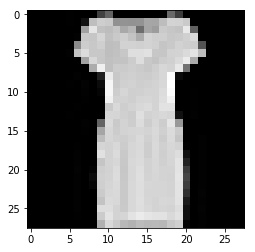

In [9]:
import matplotlib.pyplot as plt
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28, 28), cmap='gray')

In [10]:
print(train_dataset[20][1])   #Print the corresponding label for the image

3


In [11]:
#Make the dataset iterable
batch_size = 100

train_load = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = False)

In [12]:
print('There are {} images in the training set'.format(len(train_dataset)))
print('There are {} images in the test set'.format(len(test_dataset)))
print('There are {} batches in the train loader'.format(len(train_load)))
print('There are {} batches in the testloader'.format(len(test_load)))

There are 60000 images in the training set
There are 10000 images in the test set
There are 600 batches in the train loader
There are 100 batches in the testloader


* 8, 32  feature maps
* 3*3 filter


![cnn mnist](https://user-images.githubusercontent.com/30661597/61713471-3c957d00-ad8b-11e9-9a38-e3f4d1e72565.png)

**Defining our Neural Network (NN)architectures using the python class.**
* PyTorch provides a nn.Module that building neural networks.
* super().__init__() this creates a class that tracks the architecture and provides a lot of useful methods and attributes.
* In NN architecture, we defined 5 hidden layers and 1 output layer.
* self.fc1 = nn.Linear(1568, 600): This line creates a module for a linear transformation, xw+b, with 1568 inputs and 600 outputs for first hidden layer and assigns it to self.fc1. The module automatically creates the weight and bias tensors which we'll use in the forward method.

* In Forward Model, we take tensor input x to change its shapes to our batch size using x.shape[0] , the -1 fill out the second dimension.
* Then, we could pass thought operations that we defined in __init__ .The input layer goes through the hidden layer with a together dropout and RELU activation function then reassign it to the x.
* For the output layer, we do not pass through the Log Softmax function to obtain the log-probabilities in neural-network as we are using cross entropy loss.

In [13]:
#Create the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #Same Padding = [(filter size - 1) / 2] (Same Padding--> input size = output size)
        #grey channel has only 1 channel, kernel size 3 is same as 3*3
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,stride=1, padding=1)
        #The output size of each of the 8 feature maps is 28 calculated as follows
        #[(input_size - filter_size + 2(padding) / stride) +1] --> [(28-3+2(1)/1)+1] = 28 (padding type is same)
        #Batch normalization for feature maps - 8
        self.batchnorm1 = nn.BatchNorm2d(8)
        #RELU
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is now 28/2 = 14
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        #Output size of each of the 32 feature maps remains 14
        self.batchnorm2 = nn.BatchNorm2d(32)
        #After max pooling, the output of each feature map is 14/2 = 7
        #Flatten the feature maps. You have 32 feature maps, each of them is of size 7x7 --> 32*7*7 = 1568
        self.fc1 = nn.Linear(in_features=1568, out_features=600)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        #Now we have to flatten the output. This is where we apply the feed forward neural network as learned before! 
        #It will take the shape (batch_size, 1568) = (100, 1568)
        out = out.view(-1,1568) # donot have to specify 100 - batch_size. -1 is sufficient
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        return out

In [14]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()    
loss_fn = nn.CrossEntropyLoss()        
# Show weight decay
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [15]:
#Understand what's happening
iteration = 0
correct = 0

for i,(inputs,labels) in enumerate (train_load):

    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()
        
    print("For one iteration, this is what happens:")
    # each tensor propogated through the network should be a 4D shape( batch_size, channels, rows, colums)
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    output = model(inputs)
    print("Outputs Shape",output.shape)
    _, predicted = torch.max(output, 1) # maximum across the predicted class - out of 10
    print("Predicted Shape",predicted.shape)
    print("Predicted Tensor:")
    print(predicted)
    correct += (predicted == labels).sum()
    break

For one iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Outputs Shape torch.Size([100, 10])
Predicted Shape torch.Size([100])
Predicted Tensor:
tensor([8, 3, 3, 6, 3, 3, 3, 3, 2, 3, 3, 3, 8, 3, 3, 3, 3, 2, 3, 4, 6, 5, 3, 2,
        4, 1, 4, 4, 6, 3, 3, 3, 3, 3, 6, 3, 4, 8, 5, 3, 5, 0, 3, 8, 3, 3, 4, 8,
        3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 6, 3, 2, 4, 2, 9, 9, 6, 3, 3, 3, 2, 0, 6,
        4, 3, 8, 6, 4, 9, 3, 3, 4, 6, 3, 9, 7, 3, 1, 1, 6, 3, 8, 3, 1, 1, 4, 6,
        3, 3, 9, 9], device='cuda:0')


**The training pass process is as follow:**
* model = CNN()This line is actually created our model.
* Defined the criterion with Negative log-likelihood loss and also defined our optimizer (SGD)to optimize our model’s parameter when we loop through the dataset using epochs.

**We are going to track running loss and validation loss for each epoch to see the evaluation of our model.**

For training the data we set the model in train mode: model.train().Then loop over the “trainloader” to extract images and labels from a train data. The following process shows the train pass.

* zero_grad():Clear the gradients of all optimized variables
* outputs = model(inputs): Make a forward pass through the network to getting log probabilities bypassing the images to the model.
* loss_fn = nn.CrossEntropyLoss():Use the log probabilities (outputs) and labels to calculate the loss.
* loss.backward():Perform a backward pass through the network to calculate the gradients for model parameters.
* optimizer.step()Take a step with the optimizer to update the model parameters.

**We need to use test data to know when to stop training the model. So, we have validatiın batch that loop over the validation data and labels.**

In test batch, we apply the model and calculate the loss for the test data set. 

In [16]:
#Training the CNN
num_epochs = 25

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()                   # Put the network into training mode to include dropout and batch normalization. We do not do it for testing
    
    for i, (inputs, labels) in enumerate(train_load):
        
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.item()         # Accumulate the loss
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))
   
    #Testing
    testing_loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_load):

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = loss_fn(outputs, labels) # Calculate the loss
        testing_loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(testing_loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             test_loss[-1], test_accuracy[-1]))

Epoch 1/25, Training Loss: 0.828, Training Accuracy: 73.000, Testing Loss: 0.507, Testing Acc: 82.000
Epoch 2/25, Training Loss: 0.472, Training Accuracy: 83.000, Testing Loss: 0.418, Testing Acc: 85.000
Epoch 3/25, Training Loss: 0.400, Training Accuracy: 85.000, Testing Loss: 0.377, Testing Acc: 86.000
Epoch 4/25, Training Loss: 0.365, Training Accuracy: 86.000, Testing Loss: 0.348, Testing Acc: 87.000
Epoch 5/25, Training Loss: 0.339, Training Accuracy: 87.000, Testing Loss: 0.334, Testing Acc: 87.000
Epoch 6/25, Training Loss: 0.322, Training Accuracy: 88.000, Testing Loss: 0.317, Testing Acc: 88.000
Epoch 7/25, Training Loss: 0.307, Training Accuracy: 88.000, Testing Loss: 0.317, Testing Acc: 88.000
Epoch 8/25, Training Loss: 0.295, Training Accuracy: 89.000, Testing Loss: 0.308, Testing Acc: 88.000
Epoch 9/25, Training Loss: 0.283, Training Accuracy: 89.000, Testing Loss: 0.304, Testing Acc: 88.000
Epoch 10/25, Training Loss: 0.276, Training Accuracy: 90.000, Testing Loss: 0.294,

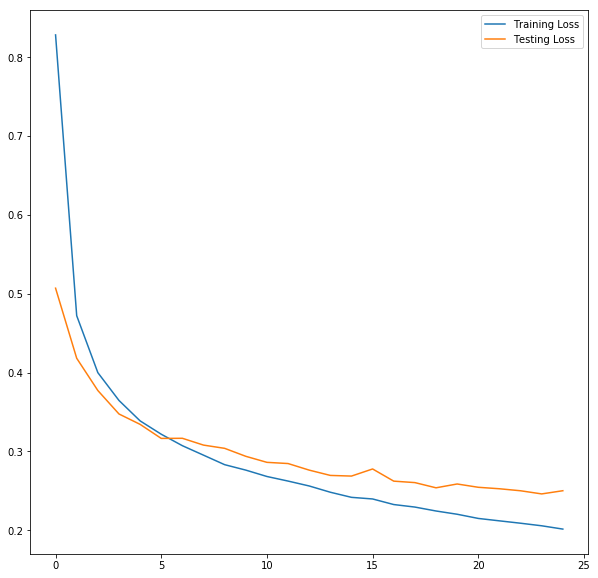

In [17]:
# Loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

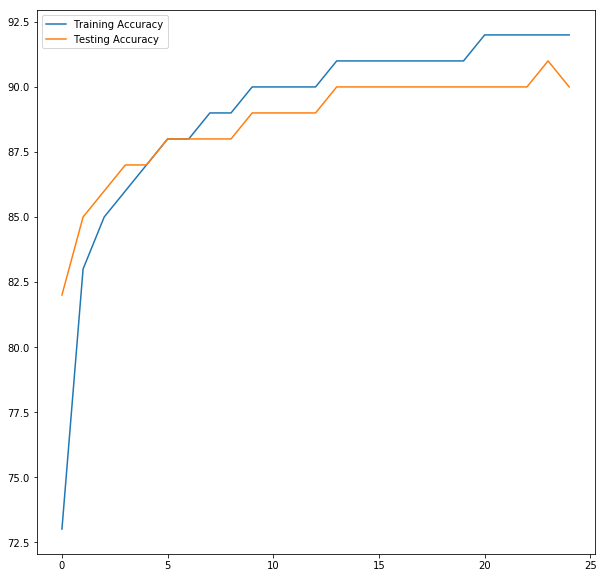

In [18]:
# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

In [19]:
img = test_dataset[30][0].resize_((1, 1, 28, 28))   #(batch_size,channels,height,width)
label = test_dataset[30][1]

model.eval()

if CUDA:
    model = model.cuda()
    img = img.cuda()
    
output = model(img)
_, predicted = torch.max(output,1)
print("Prediction is: {}".format(predicted.item()))
print("Actual is: {}".format(label))

Prediction is: 8
Actual is: 8
